## Using kNN-statistics on an N-body simulation

We explore the use of kNN-CDFs, CICs, VPFs and other statistics for halos and the DM distribution as found in the Bolshoi simulation. We use all public tools including <a href="http://halotools.readthedocs.io">halotools</a>, and <a href="http://colossus.readthedocs.io">colossus</a>. Please make sure you have those installed already.


In [1]:
import halotools
import halotools.mock_observables as mo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial
import h5py
import os
from colossus.cosmology import cosmology
from colossus.lss import peaks
from colossus.lss import bias
from scipy import interpolate
from scipy import integrate
import time

import scipy.stats as stats

import sys
sys.path.append('/Users/tabel/Research/codes/SEdist/')
from SEdist import SE_distribution

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
nthreads = 4
# plt.style.use(style.notebook)
plt.rc("text", usetex=True)
plt.rcParams["font.size"] = 28
plt.rcParams["figure.figsize"] = [16.34, 13]

In [2]:
from halotools.sim_manager import CachedHaloCatalog

bolshoi_z0 = CachedHaloCatalog()
halos = bolshoi_z0.halo_table
particles = bolshoi_z0.ptcl_table
Nhalosin = len(bolshoi_z0.halo_table)
boxsize = 250
print("Number of Halos: ", len(halos))

Number of Halos:  1367493


## Create Subsamples

To explore various clustering measures we examine halos and define some sub-samples based on virial mass.

In [3]:
msel = np.sort(halos["halo_mvir"])
halos.sort("halo_mvir")
mthresh = np.array((5e10, 1e11, 1e12, 1e13, 1e14))
ithresh = np.arange(5)
Nhthresh = np.arange(5)
count = 0
for i in mthresh:
    ithresh[count] = (np.where(msel >= i))[0][0]
    Nhthresh[count] = Nhalosin - ithresh[count] + 1
    print(
        "Greater than %8.2e Msun has %7g halos"
        % (msel[ithresh[count]], Nhthresh[count])
    )
    count = count + 1

Greater than 5.00e+10 Msun has  917419 halos
Greater than 1.00e+11 Msun has  499166 halos
Greater than 1.00e+12 Msun has   61815 halos
Greater than 1.00e+13 Msun has    6161 halos
Greater than 1.00e+14 Msun has     327 halos


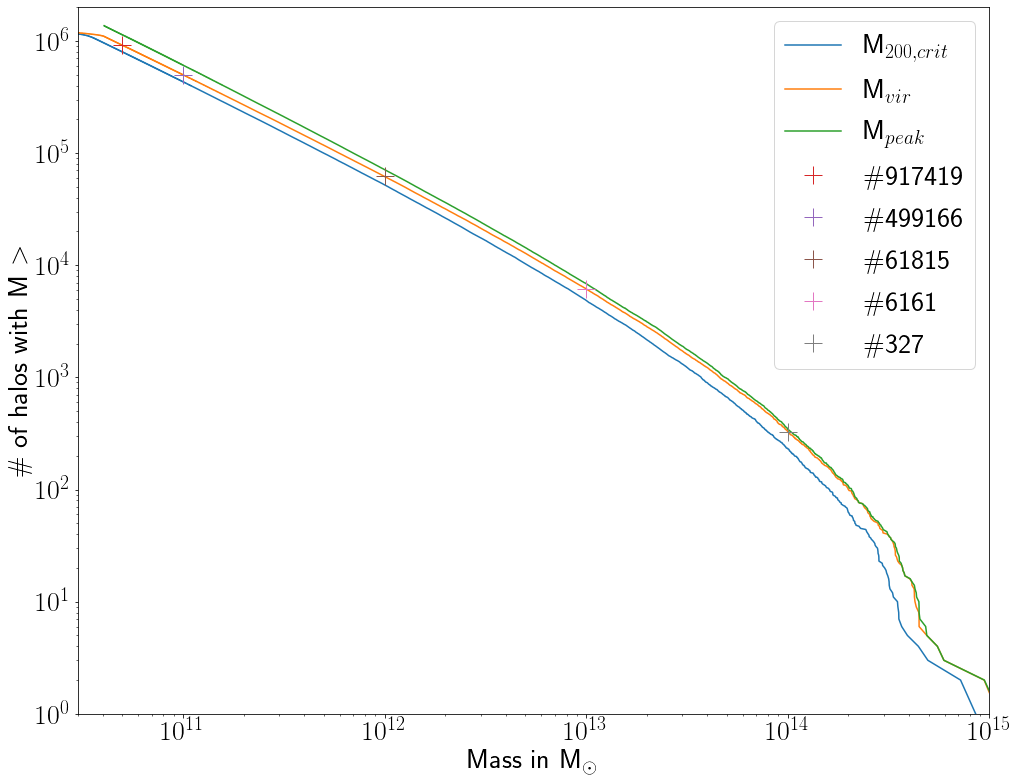

In [4]:
xMh = Nhalosin - np.arange(Nhalosin)
plt.loglog(np.sort(halos["halo_m200c"]), xMh, label=r"M$_{200,crit}$")
plt.semilogy(np.sort(halos["halo_mvir"]), xMh, label=r"M$_{vir}$")
plt.semilogy(np.sort(halos["halo_mpeak"]), xMh, label=r"M$_{peak}$")
for c, i in enumerate(ithresh):
    plt.plot(
        halos["halo_mvir"][i],
        xMh[i],
        "+",
        markersize=18,
        label=r"\#" + str(Nhthresh[c]),
    )
plt.xlabel("Mass in M$_\odot$")
plt.ylabel("$\#$ of halos with M $>$ ")
plt.xlim((3e10, 1e15))
plt.ylim((1, 2e6))

plt.legend(loc='upper right');

A Poisson Distribution for testing

In [5]:
seed = 42
np.random.seed(seed)
NPois = 1000000
X = np.random.uniform(0, boxsize, NPois)
Y = np.random.uniform(0, boxsize, NPois)
Z = np.random.uniform(0, boxsize, NPois)

## Void Probability Function and Counts in Cell

In [6]:
from scipy.special import gamma
def Erlang(k, lam, x):
    if k == 0:
        klamx = lam * x
        gammak = 1
    else:
        klamx = k * lam * x
        gammak = gamma(k)
    return (klamx) ** k / gammak * np.exp(-klamx)

## Nearest Neighbor Estimates for the VPF

White (1979) describes the natural estimator to be the nearest neighbor counts. 
For a large number of randomly chosen points, ${N_{tot}}$, the fraction of these points which have nearest neighbor distances (to nearest galaxy), $r_{1NN}$ , within a given radius $r$,  
$$
g_{1NN}(r)=\frac{1}{N_{tot}} N(r_{1NN} \gt r),
$$
is an estimate of the void probability function. The generalization to $g_{kNN}(r)$ measuring the fraction of points with $k$ nearest neighbor distances larger than $r$ can further be used as an estimator for the counts in cell probabilities. 

In [7]:
def VolumekNN(xin, xout, k=1, periodic=0):
    if isinstance(k, int): k = [k] # 
    dim = xin.shape[1]
    xtree = scipy.spatial.cKDTree(xin, boxsize=periodic)
    dis, disi = xtree.query(xout, k=k, n_jobs=-1)
    vol = np.empty_like(dis) # same shape as distance including all k values
    Cr = [2, np.pi, 4 * np.pi / 3][dim - 1]  # Volume prefactor for 1,2, 3D
    for c, k in enumerate(np.nditer(np.array(k))):
        vol[:,c] = Cr * dis[:,c]**dim
    return vol
    
def CDFkNN(xin, xout, k=1, periodic=0):
    vol = VolumekNN(xin, xout, k=k, periodic=periodic)
    for c, k in enumerate(np.nditer(np.array(k))):
        vol[:,c] = np.sort(vol[:,c])
    N = len(vol)
    cdf = 1-(np.arange(0, N) + 1) / N
    return cdf, vol


import scipy.stats as stats
from SEdist import SE_distribution



In [10]:
x_Poisson = np.vstack((X,Y,Z)).T.reshape(NPois, 3)
Nplg = int(NPois ** 0.3334) # make a lattice with approximately the same number as the input data
xpoi = boxsize * (np.arange(0, Nplg) + 0.5) / Nplg
xoutg = np.array(np.meshgrid(xpoi, xpoi, xpoi, indexing="xy"))
xoutg = xoutg.T.reshape(Nplg ** 3, 3)


In [56]:
from scipy.interpolate import interp1d
#kneighbors = np.array([1,2,3,4,5,20,21])
kneighbors = np.arange(80) # get first 30 nearest neighbors
k20 = np.where(kneighbors[:] == 20)[0][0]

cdf_Poisson, vol_Poisson,  = CDFkNN(x_Poisson, xoutg, k=kneighbors, periodic=250)

CDFs = [SE_distribution(vol_Poisson[:,k],compress="log",Ninterpolants=500) for k in kneighbors]
CICs = [interp1d(CDFs[k].f.x,CDFs[k-1].cdf(CDFs[k].f.x)-CDFs[k].cdf(CDFs[k].f.x), bounds_error=False,fill_value=(0,0))  for k in kneighbors]

(0.001, 10.0)

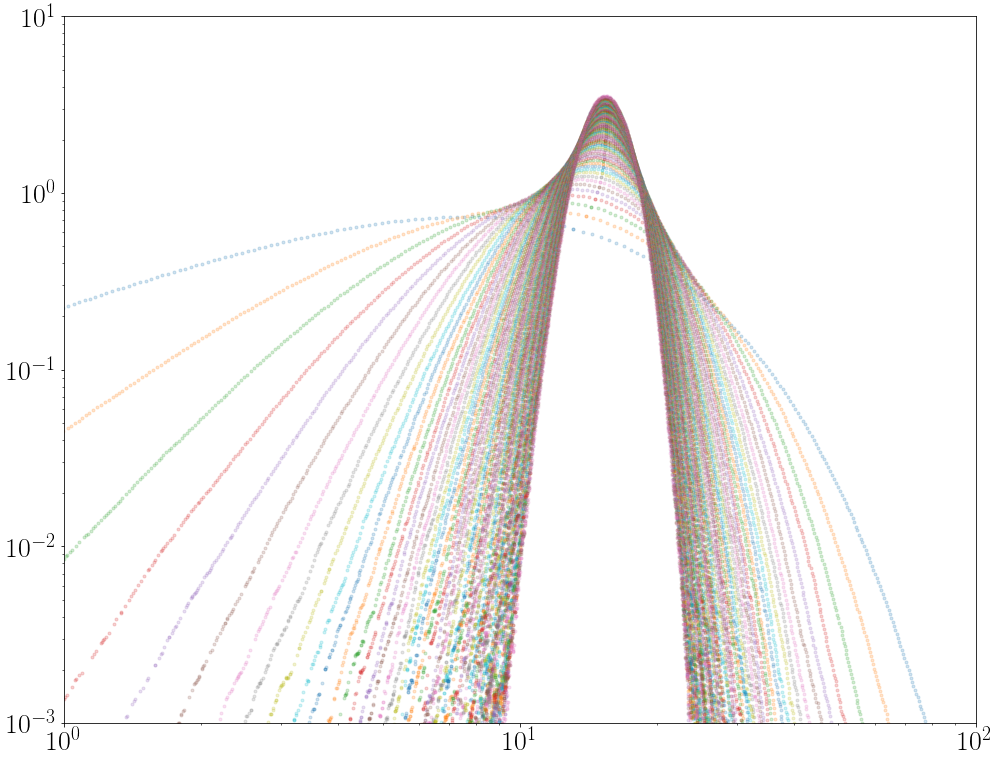

In [61]:
k=2
#plt.loglog(CDFs[1].f.x, CDFs[k-1].cdf(CDFs[k].f.x)-CDFs[k].cdf(CDFs[k].f.x))
for k in range(2,79):
    plt.loglog(CDFs[k].f.x/k, k*CICs[k](CDFs[k].f.x),'.',alpha=.2)

plt.xlim([1e0,1e2])
plt.ylim([1e-3,1e1])

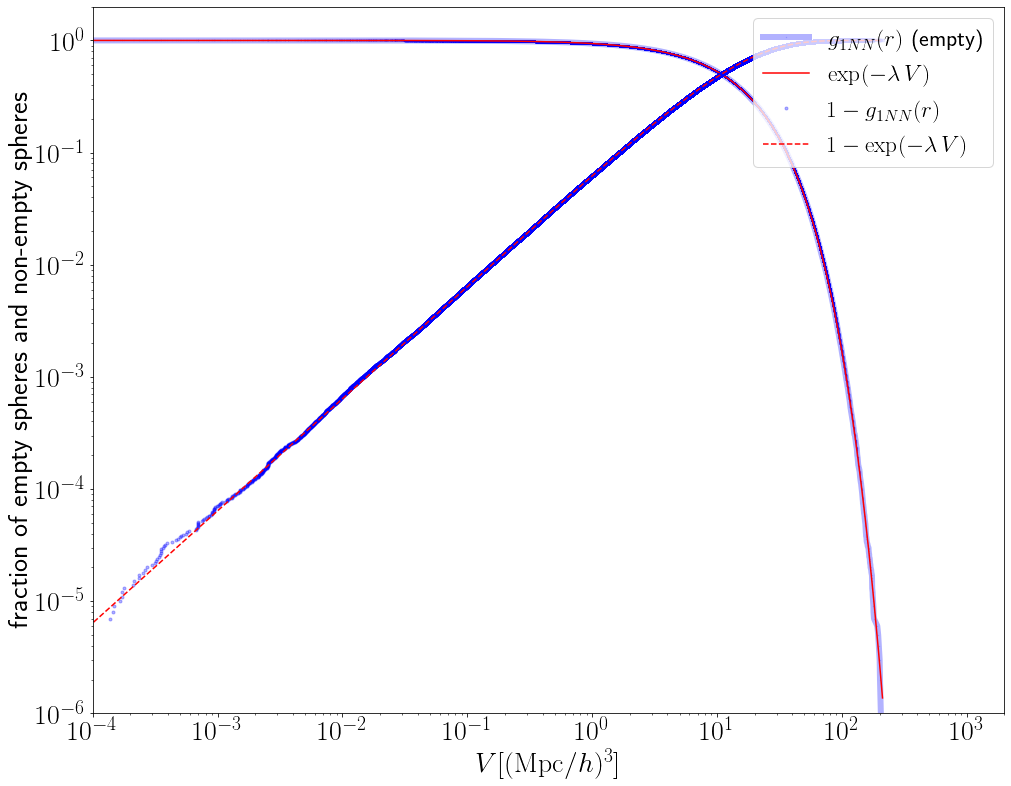

In [17]:
plt.loglog(vol_Poisson[:,0], gofr_Poisson, "b.-", ms=.5, linewidth=6,label=r"$g_{1NN}(r)$ (empty)",alpha=.3)
plt.plot(vol_Poisson[:,0], np.exp( - NPois/250**3 *vol_Poisson[:,0]),"r-", label=r"$\exp(-\lambda\, V)$")
plt.loglog(vol_Poisson[:,0], 1-gofr_Poisson, "b.", label=r"$1-g_{1NN}(r)$",alpha=.3)
plt.plot(vol_Poisson[:,0], 1-np.exp( - NPois/250**3 *vol_Poisson[:,0]),"r--",label=r"$1-\exp(-\lambda\, V)$")

plt.xlim(1e-4, 2e3)
plt.ylim(1e-6, 2)

plt.legend(loc='upper right',fontsize='small')
plt.xlabel(r"$V [({\rm Mpc}/h)^3]$")
plt.ylabel("fraction of empty spheres and non-empty spheres");

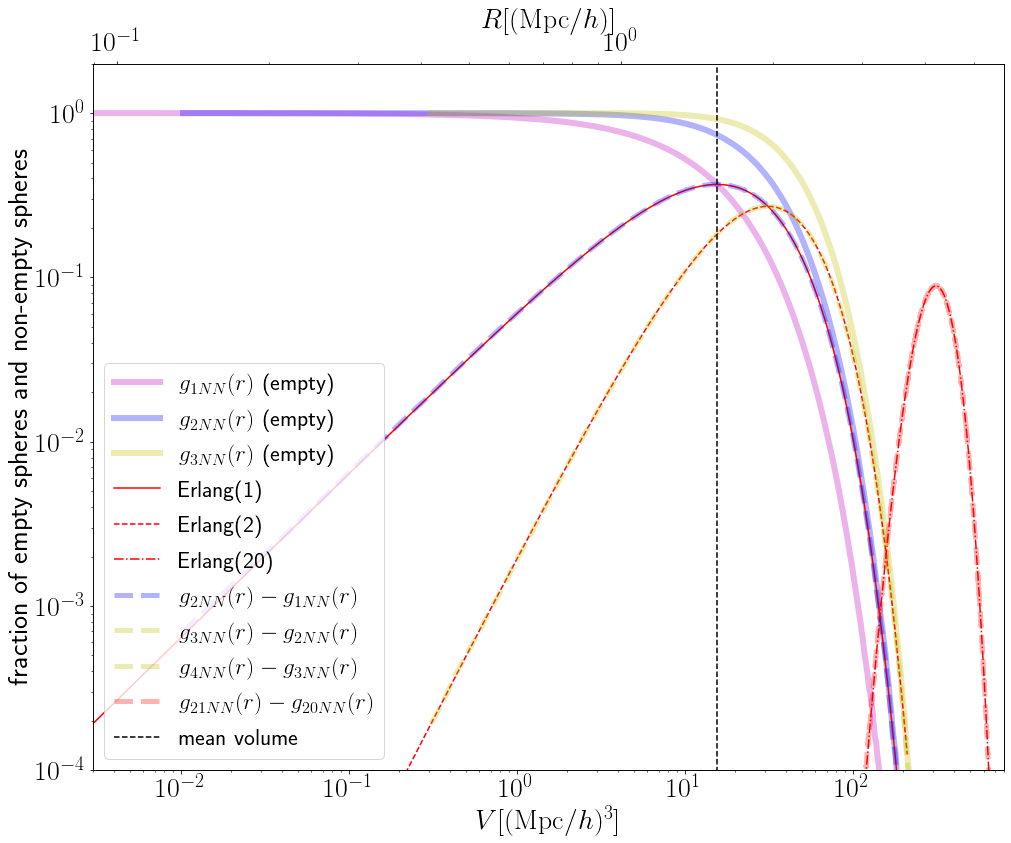

In [20]:
R_Poisson = (vol_Poisson/4/np.pi*3)**.333334

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.loglog(vol_Poisson[:,0], gofr_Poisson, "m-", ms=.25, linewidth=6,label=r"$g_{1NN}(r)$ (empty)",alpha=.3)
ax1.loglog(vol_Poisson[:,1], gofr_Poisson, "b-", ms=.5, linewidth=6,label=r"$g_{2NN}(r)$ (empty)",alpha=.3)
ax1.loglog(vol_Poisson[:,2], gofr_Poisson, "y-", ms=.25, linewidth=6,label=r"$g_{3NN}(r)$ (empty)",alpha=.3)

ax1.plot(vol_Poisson[:,0], Erlang(1,NPois/250**3,vol_Poisson[:,0]),"r-", label="Erlang(1)")
ax1.plot(vol_Poisson[:,0], Erlang(2,NPois/250**3,vol_Poisson[:,0]/2)/2,"r--", label="Erlang(2)")
ax1.plot(vol_Poisson[:,k20], Erlang(20,NPois/250**3,vol_Poisson[:,k20]/20)/20,"r-.", label="Erlang(20)")


i_CDFPoisson1NN = interpolate.interp1d(vol_Poisson[:,0], gofr_Poisson, kind=1)
sel = np.where(vol_Poisson[:,1] < np.max(vol_Poisson[:,0]))[0]
ax1.plot(vol_Poisson[sel,1], gofr_Poisson[sel]-i_CDFPoisson1NN(vol_Poisson[sel,1]),
         'b--',label=r"$g_{2NN}(r) - g_{1NN}(r)$",alpha=.3, linewidth=5)

i_CDFPoisson2NN = interpolate.interp1d(vol_Poisson[:,1], gofr_Poisson, kind=1)
sel = np.where(vol_Poisson[:,2] < np.max(vol_Poisson[:,1]))[0]
ax1.plot(vol_Poisson[sel,2], gofr_Poisson[sel]-i_CDFPoisson2NN(vol_Poisson[sel,2]),
         'y--',label=r"$g_{3NN}(r) - g_{2NN}(r)$",alpha=.3, linewidth=5)

i_CDFPoisson3NN = interpolate.interp1d(vol_Poisson[:,2], gofr_Poisson, kind=1)
sel = np.where(vol_Poisson[:,3] < np.max(vol_Poisson[:,2]))[0]
ax1.plot(vol_Poisson[sel,2], gofr_Poisson[sel]-i_CDFPoisson3NN(vol_Poisson[sel,3]),
         'y--',label=r"$g_{4NN}(r) - g_{3NN}(r)$",alpha=.3, linewidth=5)

i_CDFPoisson20NN = interpolate.interp1d(vol_Poisson[:,k20], gofr_Poisson, kind=1)
sel = np.where(vol_Poisson[:,k20+1] < np.max(vol_Poisson[:,k20]))[0]
ax1.plot(vol_Poisson[sel,k20+1], gofr_Poisson[sel]-i_CDFPoisson20NN(vol_Poisson[sel,k20+1]),
         'r--',label=r"$g_{21NN}(r) - g_{20NN}(r)$",alpha=.3, linewidth=5)


ax1.plot(250**3/1e6*np.array([1,1]),[1e-8,1e6],'k--',label="mean volume")

ax1.set_xlim(3e-3, 8e2)
ax1.set_ylim(1e-4, 2)
ax2.set_xlim(((np.array(ax1.get_xlim()))/4/np.pi*3)**0.33334)
ax2.set_xlabel(r"$R [({\rm Mpc}/h)]$")
ax2.set_xscale("log")
ax1.legend(loc='lower left',fontsize='small')
ax1.set_xlabel(r"$V [({\rm Mpc}/h)^3]$")
ax1.set_ylabel("fraction of empty spheres and non-empty spheres");

So we can use 

### Now for the DM particles

In [ ]:
numpN = 1250
vpfr = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    particles["x"],
    particles["y"],
    particles["z"],
    periodic=True,
    boxsize=250,
    verbose=True,
)

Ndm = len(particles["x"])
x_dm = np.vstack((
    particles["x"],
    particles["y"],
    particles["z"])).T.reshape(Ndm, 3)

t0 = time.time()
gofr_dm, vol_dm,  = VPFkNN(x_dm, xoutg, k=kneighbors, periodic=250)
print("kNN estimate time take: ","{:6.2f}".format(time.time()-t0), " secs")

In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 6,6,6.  Time taken =   0.022 sec
Running with [xmin,xmax] = 0.000097,249.999847 with periodic wrapping = 250.000000
Running with [ymin,ymax] = 0.000127,249.999817 with periodic wrapping = 250.000000
Running with [zmin,zmax] = 0.000037,249.999847 with periodic wrapping = 250.000000
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =     3 mins    4 secs


TypeError: __init__() got an unexpected keyword argument 'njobs'

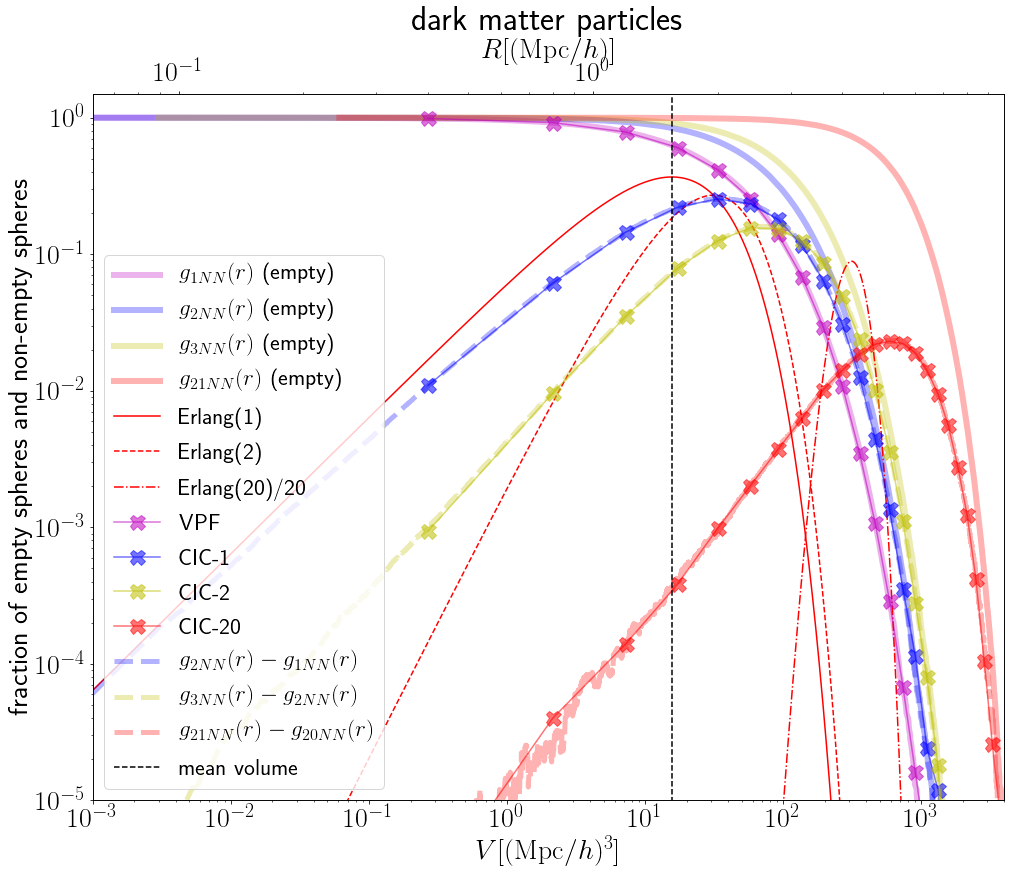

In [ ]:
R_dm = (vol_dm/4/np.pi*3)**.333334

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.loglog(vol_dm[:,0], gofr_dm, "m-", ms=.25, linewidth=6,label=r"$g_{1NN}(r)$ (empty)",alpha=.3)
ax1.loglog(vol_dm[:,1], gofr_dm, "b-", ms=.5, linewidth=6,label=r"$g_{2NN}(r)$ (empty)",alpha=.3)
ax1.loglog(vol_dm[:,2], gofr_dm, "y-", ms=.25, linewidth=6,label=r"$g_{3NN}(r)$ (empty)",alpha=.3)
ax1.loglog(vol_dm[:,k20+1], gofr_dm, "r-", ms=.25, linewidth=6,label=r"$g_{21NN}(r)$ (empty)",alpha=.3)


ax1.plot(vol_dm[:,0], Erlang(1,NPois/250**3,vol_dm[:,0]),"r-", label="Erlang(1)")
ax1.plot(vol_dm[:,0], Erlang(2,NPois/250**3,vol_dm[:,0]/2)/2,"r--", label="Erlang(2)")
ax1.plot(vol_dm[:,k20], Erlang(20,NPois/250**3,vol_dm[:,k20]/20)/20,"r-.", label="Erlang(20)/20")

#plt.loglog(vol_dm[:,1], 1-gofr_dm, "b.", label=r"$1-g_{1NN}(r)$",alpha=.3)
ax1.plot(VNN, vpfr["pN"][:, 0], "mX-", label=r"VPF",ms=15,alpha=0.55)
ax1.plot(VNN, vpfr["pN"][:, 1], "bX-", label=r"CIC-1",ms=15,alpha=0.55)
ax1.plot(VNN, vpfr["pN"][:, 2], "yX-", label=r"CIC-2",ms=15,alpha=0.55)
ax1.plot(VNN, vpfr["pN"][:,20], "rX-", label=r"CIC-20",ms=15,alpha=0.55)


i_CDFdm1NN = interpolate.interp1d(vol_dm[:,0], gofr_dm, kind=1)
sel = np.where(vol_dm[:,1] < np.max(vol_dm[:,0]))[0]
ax1.plot(vol_dm[sel,1], gofr_dm[sel]-i_CDFdm1NN(vol_dm[sel,1]),
         'b--',label=r"$g_{2NN}(r) - g_{1NN}(r)$",alpha=.3, linewidth=5)

i_CDFdm2NN = interpolate.interp1d(vol_dm[:,1], gofr_dm, kind=1)
sel = np.where(vol_dm[:,2] < np.max(vol_dm[:,1]))[0]
ax1.plot(vol_dm[sel,2], gofr_dm[sel]-i_CDFdm2NN(vol_dm[sel,2]),
         'y--',label=r"$g_{3NN}(r) - g_{2NN}(r)$",alpha=.3, linewidth=5)

i_CDFdm20NN = interpolate.interp1d(vol_dm[:,k20], gofr_dm, kind=1)
sel = np.where(vol_dm[:,k20+1] < np.max(vol_dm[:,k20]))[0]
ax1.plot(vol_dm[sel,k20+1], gofr_dm[sel]-i_CDFdm20NN(vol_dm[sel,k20+1]),
         'r--',label=r"$g_{21NN}(r) - g_{20NN}(r)$",alpha=.3, linewidth=5)


ax1.plot(boxsize**3/Ndm*np.array([1,1]),[1e-8,1e6],'k--',label="mean volume")

ax1.set_xlim(1e-3, 4e3)
ax1.set_ylim(1e-5, 1.5)
ax2.set_xlim(((np.array(ax1.get_xlim()))/4/np.pi*3)**0.33334)
ax2.set_xlabel(r"$R [({\rm Mpc}/h)]$")
ax2.set_xscale("log")
ax1.legend(loc="lower left",fontsize="small")
ax1.set_title("dark matter particles")
ax1.set_xlabel(r"$V [({\rm Mpc}/h)^3]$")
ax1.set_ylabel("fraction of empty spheres and non-empty spheres");
plt.savefig('foo.pdf', bbox_inches='tight');

In [ ]:
t0 = time.time()
uvol_dm  = VolumekNN(x_dm, xoutg, k=kneighbors, periodic=250)
print("kNN Volume estimate time taken: ","{:6.2f}".format(time.time()-t0), " secs")

NameError: name 'x_dm' is not defined

In [ ]:
dvol2 = uvol_dm[:,1]-uvol_dm[:,0]
dvol3 = uvol_dm[:,2]-uvol_dm[:,1]
dvol4 = uvol_dm[:,3]-uvol_dm[:,2]
dvol21 = uvol_dm[:,k20+1]-uvol_dm[:,k20]

sdvol2 = np.sort(dvol2)
sdvol3 = np.sort(dvol3)
sdvol4 = np.sort(dvol4)
sdvol21 = np.sort(dvol21)

NameError: name 'uvol_dm' is not defined

In [ ]:
plt.loglog(sdvol2,1-gofr_dm,'k')
plt.loglog(sdvol3,1-gofr_dm,'b')
plt.loglog(sdvol4,1-gofr_dm,'r')
plt.loglog(sdvol21,1-gofr_dm,'g')
plt.loglog(sdvol2,gofr_dm,'k')
plt.loglog(sdvol3,gofr_dm,'b')
plt.loglog(sdvol4,gofr_dm,'r')
plt.loglog(sdvol21,gofr_dm,'g')


plt.loglog(vol_dm[:,0],   gofr_dm, "m-", ms=.25, linewidth=6,label=r"$g_{1NN}(r)$ (empty)",alpha=.3)
plt.loglog(vol_dm[:,0], 1-gofr_dm, "m-", ms=.25, linewidth=6,label=r"$g_{1NN}(r)$ (empty)",alpha=.3)

NameError: name 'sdvol2' is not defined

In [ ]:
plt.loglog(uvol_dm[:,0],dvol2,'.',alpha=.1)
plt.loglog([1e-6,1e-6],[1e6,1e6],'k','.',alpha=.1)
plt.xlim(1e-2,1e3)
plt.ylim(1e-2,1e3)

In [ ]:
gofr_dm

NameError: name 'gofr_dm' is not defined

In [ ]:
xNN = np.arange(len(vpfr["pN"][0]))
for i, rad in enumerate(vpfr["rmax"]):
    plt.plot(xNN+1, vpfr["pN"][i], "X-", label=r"R = {0:8.2f}".format(rad))

plt.xlabel("Counts per sphere + 1")
plt.ylabel("fraction of spheres")
plt.yscale("log")
plt.xscale("log")

plt.ylim(1e-5, 1)
plt.xlim(0.9, 950)
plt.legend(ncol=4,fontsize="small")

In [ ]:
VNN = vpfr["rmax"] ** 3 * 4 * np.pi / 3

ff = plt.figure(figsize=(20, 20))
f, (ax1, ax2) = plt.subplots(1, 2, sharey="row")

sskip = 3
ax2.loglog(VNN, vpfr["pN"][:, 0], "X-", label=r"\#=0", linewidth=4)
for i, rad in enumerate(vpfr["rmax"][1::sskip]):
    ax2.plot(
        VNN,
        vpfr["pN"][:, i * sskip + 1],
        "X-",
        label=r"\#=" + str(i * sskip + 1),
        alpha=0.35,
    )

ax1.loglog(VNN, vpfr["pN"][:, 0], "X-", label=r"\#=0", linewidth=4)
for i, rad in enumerate(vpfr["rmax"][1::sskip]):
    ax1.plot(
        VNN / (i * sskip + 1),
        vpfr["pN"][:, i * sskip + 1] * (i * sskip + 1),
        "X-",
        label=r"\#=" + str(i * sskip + 1),
        alpha=0.35,
    )

xV = np.logspace(-1, 3.5, 100)
lamP = 1e6 / 250 ** 3
ax1.plot(xV, np.exp(-xV * lamP), "--", label="poisson", alpha=0.5)
ax1.plot(xV, lamP * xV * np.exp(-xV * lamP), "--", label="Erlang(1)", alpha=0.5)


ax2.set_xlabel(r"Volume [(Mpc/h)$^3$]")
ax2.set_ylabel("fraction of spheres")
ax2.yaxis.set_label_position("right")

plt.yscale("log")
plt.xscale("log")
ax1.set_xlabel(r"Volume/count [(Mpc/h)$^3$]")
ax1.set_ylabel("fraction of spheres * count")

ax1.legend(fontsize="small")
ax1.set_xlim(1e-1, 1e3)
plt.ylim(1e-4, 3e0)
plt.legend(fontsize="small")

NameError: name 'vpfr' is not defined

In [ ]:
vpfr.

### VPFs of halos

In [ ]:
numpN = 1250
vpfh1 = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    halos["halo_x"][ithresh[0] : ithresh[1]],
    halos["halo_y"][ithresh[0] : ithresh[1]],
    halos["halo_z"][ithresh[0] : ithresh[1]],
    periodic=True,
    boxsize=250,
    verbose=True,
)
vpfh2 = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    halos["halo_x"][ithresh[1] : ithresh[2]],
    halos["halo_y"][ithresh[1] : ithresh[2]],
    halos["halo_z"][ithresh[1] : ithresh[2]],
    periodic=True,
    boxsize=250,
    verbose=True,
)
vpfh3 = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    halos["halo_x"][ithresh[2] : ithresh[3]],
    halos["halo_y"][ithresh[2] : ithresh[3]],
    halos["halo_z"][ithresh[2] : ithresh[3]],
    periodic=True,
    boxsize=250,
    verbose=True,
)
vpfh4 = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    halos["halo_x"][ithresh[3] : ithresh[4]],
    halos["halo_y"][ithresh[3] : ithresh[4]],
    halos["halo_z"][ithresh[3] : ithresh[4]],
    periodic=True,
    boxsize=250,
    verbose=True,
)
vpfh5 = vpf(
    rmax,
    nbins,
    nspheres,
    numpN,
    seed,
    halos["halo_x"][ithresh[4] :],
    halos["halo_y"][ithresh[4] :],
    halos["halo_z"][ithresh[4] :],
    periodic=True,
    boxsize=250,
    verbose=True,
)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 6,6,6.  Time taken =   0.004 sec
Running with [xmin,xmax] = 0.000390,249.999115 with periodic wrapping = 250.000000
Running with [ymin,ymax] = 0.000400,249.999725 with periodic wrapping = 250.000000
Running with [zmin,zmax] = 0.000010,249.998810 with periodic wrapping = 250.000000
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 44.938 secs
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 6,6,6.  Time taken =   0.005 sec
Running with [xmin,xmax] = 0.001390,249.999023 with periodic wrapping = 250.000000
Running with [ymin,ymax] = 0.000810,249.998184 with periodic wrapping = 250.000000
Running with [zmin,zmax] = 0.000270,249.999542 with periodic wrapping = 250.000000
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 45.867 secs


In [ ]:
lw = 4
plt.loglog(
    VNN / (250 ** 3 / 1e6), vpfr["pN"][:, 0], "X-", linewidth=lw, label="dark matter"
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[0] - Nhthresh[1])),
    vpfh1["pN"][:, 0],
    "X-",
    linewidth=lw,
    label="$5\cdot 10^{10} < M < 10^{11}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[1] - Nhthresh[2])),
    vpfh2["pN"][:, 0],
    "X-",
    linewidth=lw,
    label="$ 10^{11} < M < 10^{12}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[2] - Nhthresh[3])),
    vpfh3["pN"][:, 0],
    "X-",
    linewidth=lw,
    label="$10^{12} < M < 10^{13}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[3] - Nhthresh[4])),
    vpfh4["pN"][:, 0],
    "X-",
    linewidth=lw,
    label="$10^{13} < M < 10^{14}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[4])),
    vpfh5["pN"][:, 0],
    "X-",
    linewidth=lw*5,alpha=.3,
    label="$ 10^{14} < M $",
)

plt.xlim(1e-2, 1e2)
plt.ylim(1e-3, 2)
plt.legend(fontsize="small")
plt.xlabel(r"$V/\bar{V}$")
plt.ylabel("fraction of empty spheres")

In [ ]:
vpfh4["pN"][:,0]

array([9.94095981e-01, 9.57445979e-01, 8.76479983e-01, 7.56020010e-01,
       6.13241971e-01, 4.66876000e-01, 3.33272010e-01, 2.23058000e-01,
       1.39714003e-01, 8.16939995e-02, 4.48440015e-02, 2.26840004e-02,
       1.03359995e-02, 4.41600010e-03, 1.72800000e-03, 6.20000006e-04,
       1.44000005e-04, 1.20000004e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [ ]:
lw = 2
plt.loglog(
    VNN,
    vpfr["pN"][:, 0] / Erlang(0, (1e6 / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="dark matter",
)
plt.loglog(
    VNN,
    np.abs(vpfh1["pN"][:, 0] / Erlang(0, (Nhthresh[0] / 250 ** 3), VNN) - 1),
    "X-",
    linewidth=lw,
    label="$5\cdot 10^{10} < M < 10^{11}$",
)
plt.loglog(
    VNN,
    vpfh2["pN"][:, 0] / Erlang(0, (Nhthresh[1] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$ 10^{11} < M < 10^{12}$",
)
plt.loglog(
    VNN,
    vpfh3["pN"][:, 0] / Erlang(0, (Nhthresh[2] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$10^{12} < M < 10^{13}$",
)
plt.loglog(
    VNN,
    vpfh4["pN"][:, 0] / Erlang(0, (Nhthresh[3] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$10^{13} < M < 10^{14}$",
)
plt.loglog(
    VNN,
    vpfh5["pN"][:, 0] / Erlang(0, (Nhthresh[4] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$ 10^{14} < M $",
)
plt.plot([1e-3, 1e6], [1, 1])

plt.xlim(1, 1e3)
plt.ylim(1e-5, 2e19)
plt.legend()

In [ ]:
Nhthresh

array([917419, 499166,  61815,   6161,    327])

In [ ]:
lw = 2
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    vpfr["pN"][:, 1] / Erlang(1, (1e6 / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="dark matter",
)
plt.loglog(
    VNN / (250 ** 3 / Nhthresh[0]),
    np.abs(vpfh1["pN"][:, 1] / Erlang(1, (Nhthresh[0] / 250 ** 3), VNN) - 1),
    "X-",
    linewidth=lw,
    label="$5\cdot 10^{10} < M < 10^{11}$",
)
plt.loglog(
    VNN / (250 ** 3 / Nhthresh[1]),
    vpfh2["pN"][:, 1] / Erlang(1, (Nhthresh[1] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$ 10^{11} < M < 10^{12}$",
)
plt.loglog(
    VNN / (250 ** 3 / Nhthresh[2]),
    vpfh3["pN"][:, 1] / Erlang(1, (Nhthresh[2] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$10^{12} < M < 10^{13}$",
)
plt.loglog(
    VNN / (250 ** 3 / Nhthresh[3]),
    vpfh4["pN"][:, 1] / Erlang(1, (Nhthresh[3] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$10^{13} < M < 10^{14}$",
)
plt.loglog(
    VNN / (250 ** 3 / Nhthresh[4]),
    vpfh5["pN"][:, 1] / Erlang(1, (Nhthresh[4] / 250 ** 3), VNN) - 1,
    "X-",
    linewidth=lw,
    label="$ 10^{14} < M $",
)
plt.plot([1e-3, 1e6], [1, 1])
plt.ylim(1e-15, 2e19)
plt.xlim(1e-1, 2e2)
plt.legend()

In [ ]:
np.random.seed(42)
xoutt = np.random.rand(1000000, 3) * 250
xint = np.random.rand(1000000, 3) * 250
np.floor(len(xoutt) ** 0.3334)

ktest = [1, 2, 3, 5, 10, 30, 100]
xpd = np.vstack((particles["x"], particles["y"], particles["z"])).T.reshape(
    len(particles["x"]), 3)
CDFdm, Vdm = VPFkNN(xpd, xoutt, periodic=250)
CDFdmg, Vdmg = VPFkNN(xpd, xoutg, periodic=250)
CDFs, Vs = VPFkNN(xint, xoutt, periodic=250)
skipi = 100
CDFdm = CDFdm[::skipi]
Vdm = Vdm[::skipi]
CDFdmg = CDFdmg[::skipi]
Vdmg = Vdmg[::skipi]
CDFs = CDFs[::skipi]
Vs = Vs[::skipi]

TypeError: __init__() got an unexpected keyword argument 'njobs'

In [ ]:
np.median(Vs)

In [ ]:
me = 1
plt.plot(Vs, CDFs, ".", markevery=me, label="Poisson measured")
plt.plot(Vs[::100], np.exp(-Vs)[::100], label="Poisson expected")
plt.plot(Vs, 1 - CDFs, ".", markevery=me, label="Poisson measured")
plt.plot(Vs[::100], 1 - np.exp(-Vs[::100]), markevery=me, label="Poisson expected")

plt.plot(Vdm, CDFdm, ".-", markevery=me, label="DM non-empty")
plt.plot(Vdm, 1 - CDFdm, "r.-", markevery=me, alpha=0.1, ms=8.9)
plt.plot(Vdmg, 1 - CDFdmg, "r.-", markevery=me, alpha=0.3, ms=0.2, label="DM non-empty")

plt.legend()
plt.yscale("log")
plt.xscale("log")

NameError: name 'Vs' is not defined

Now lets compare with the traditional VPF approach from earlier.

In [ ]:
lw = 4
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    vpfr["pN"][:, 0],
    "bH-",
    linewidth=lw,
    alpha=0.5,
    label="dark matter empty",
)
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    1 - vpfr["pN"][:, 0],
    "bX-",
    linewidth=lw,
    alpha=0.5,
    label="dark matter non-empty",
)

plt.plot(Vdmg, 1 - CDFdmg, "g--", ms=3, alpha=0.5, label="dark matter 1NN empty")
plt.plot(Vdmg, CDFdmg, "g-", ms=3, alpha=0.5, label="dark matter 1NN non-empty")

plt.xlabel(r"$V/\bar{V}$")
plt.ylabel("fraction of empty and non-empty spheres")
plt.title("Comparison of 1NN and empty sphere estimator")
plt.xlim(1e-4, 3e2)
plt.ylim(1e-5, 2)
plt.legend()

Indeed the nearest neighbor density estimator measures exactly the void probability function without requiring binning.

In [ ]:

xpd = np.vstack((particles["x"], particles["y"], particles["z"])).T.reshape(
    len(particles["x"]), 3
)
xph1 = np.vstack(
    (
        halos["halo_x"][ithresh[0] : ithresh[1]],
        halos["halo_y"][ithresh[0] : ithresh[1]],
        halos["halo_z"][ithresh[0] : ithresh[1]],
    )
).T.reshape(len(halos["halo_x"][ithresh[0] : ithresh[1]]), 3)
xph2 = np.vstack(
    (
        halos["halo_x"][ithresh[1] : ithresh[2]],
        halos["halo_y"][ithresh[1] : ithresh[2]],
        halos["halo_z"][ithresh[1] : ithresh[2]],
    )
).T.reshape(len(halos["halo_x"][ithresh[1] : ithresh[2]]), 3)
xph3 = np.vstack(
    (
        halos["halo_x"][ithresh[2] : ithresh[3]],
        halos["halo_y"][ithresh[2] : ithresh[3]],
        halos["halo_z"][ithresh[2] : ithresh[3]],
    )
).T.reshape(len(halos["halo_x"][ithresh[2] : ithresh[3]]), 3)

CDFh1, Vsh1 = VPFkNN(xph1, xoutt, periodic=250)
CDFh2, Vsh2 = VPFkNN(xph2, xoutt, periodic=250)
CDFh3, Vsh3 = VPFkNN(xph3, xoutt, periodic=250)

TypeError: __init__() got an unexpected keyword argument 'njobs'

In [ ]:
lw = 4
# plt.loglog(VNN/(250**3/1e6), vpfr["pN"][:,0], 'bH-',linewidth=lw, alpha=.5, label="dark matter empty")
# plt.loglog(VNN/(250**3/1e6), 1- vpfr["pN"][:,0], 'bX-',linewidth=lw, alpha=.5, label="dark matter non-empty")
# plt.loglog(VNN/(250**3/(Nhthresh[0]-Nhthresh[1])), vpfh1["pN"][:,0], 'bH-',linewidth=lw, alpha=.5, label="$5\cdot 10^{10} < M < 10^{11}$")
# plt.loglog(VNN/(250**3/(Nhthresh[0]-Nhthresh[1])), 1-vpfh1["pN"][:,0], 'bX-',linewidth=lw, alpha=.5, label="$5\cdot 10^{10} < M < 10^{11}$")
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[1] - Nhthresh[2])),
    vpfh2["pN"][:, 0],
    "bX-",
    linewidth=lw,
    alpha=0.5,
    label="$ 10^{11} < M < 10^{12}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[1] - Nhthresh[2])),
    1 - vpfh2["pN"][:, 0],
    "bX-",
    linewidth=lw,
    alpha=0.5,
    label="$ 10^{11} < M < 10^{12}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[2] - Nhthresh[3])),
    vpfh3["pN"][:, 0],
    "rX-",
    linewidth=lw,
    alpha=0.5,
    label="$10^{12} < M < 10^{13}$",
)
plt.loglog(
    VNN / (250 ** 3 / (Nhthresh[2] - Nhthresh[3])),
    1 - vpfh3["pN"][:, 0],
    "rX-",
    linewidth=lw,
    alpha=0.5,
    label="$10^{12} < M < 10^{13}$",
)
# plt.loglog(VNN/(250**3/(Nhthresh[3]-Nhthresh[4])), vpfh4["pN"][:,0], 'X-',linewidth=lw, alpha=.5, label="$10^{13} < M < 10^{14}$")
# plt.loglog(VNN/(250**3/(Nhthresh[4])), vpfh5["pN"][:,0], 'X-',linewidth=lw, alpha=.5, label="$ 10^{14} < M $")

# plt.plot(Vsh1, 1-nih1/Nph1,  "g--", ms=3, alpha=.5, label="$5\cdot 10^{10} < M < 10^{11}$ empty" )
# plt.plot(Vsh1, nih1/Nph1,  "g-", ms=3, alpha=.5, label="$5\cdot 10^{10} < M < 10^{11}$ 1NN non-empty" )
plt.plot(
    Vsh2, 1 - CDFh2, "b--", ms=3, alpha=0.5, label="$ 10^{11} < M < 10^{12}$ 1NN empty"
)
plt.plot(
    Vsh2, CDFh2, "b-", ms=3, alpha=0.5, label="$ 10^{11} < M < 10^{12}$ 1NN non-empty"
)
plt.plot(
    Vsh3, 1 - CDFh3, "r--", ms=3, alpha=0.5, label="$10^{12} < M < 10^{13}$ 1NN empty"
)
plt.plot(
    Vsh3, CDFh3, "r-", ms=3, alpha=0.5, label="$10^{12} < M < 10^{13}$ 1NN non-empty"
)

plt.xlabel(r"$V/\bar{V}$")
plt.ylabel("fraction of empty and non-empty spheres")
plt.title("Differences for Halos of different mass")
plt.xlim(1e-4, 3e2)
plt.ylim(1e-5, 2)
plt.legend()

One further clear advantage of the parameter free 1NN estimator is that is automatically picks out all volumes that can be meaningfully probed given the data.

In [ ]:
np.random.seed(42)
Np = xpd.shape[0]
Np2 = int(Np / 2)
Np34 = int(Np / 4 * 3)
Np4 = int(Np / 4)
Np8 = int(Np / 8)

CDFdmg, Vdmg = VPFkNN(xpd, xoutg, periodic=250)
CDFdmg34, Vdmg34 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np34), :], xoutg, periodic=250
)
CDFdmg2, Vdmg2 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np2), :], xoutg, periodic=250
)
CDFdmg4, Vdmg4 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np4), :], xoutg, periodic=250
)
CDFdmg8, Vdmg8 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np8), :], xoutg, periodic=250
)

skipi = 10
CDFdmg = CDFdmg[::skipi]
Vdmg = Vdmg[::skipi] * 250 ** 3 / Np
CDFdmg2 = CDFdmg2[::skipi]
Vdmg2 = Vdmg2[::skipi] * 250 ** 3 / Np2
CDFdmg4 = CDFdmg4[::skipi]
Vdmg4 = Vdmg4[::skipi] * 250 ** 3 / Np4
CDFdmg34 = CDFdmg34[::skipi]
Vdmg34 = Vdmg34[::skipi] * 250 ** 3 / Np34
CDFdmg8 = CDFdmg8[::skipi]
Vdmg8 = Vdmg8[::skipi] * 250 ** 3 / Np8

TypeError: __init__() got an unexpected keyword argument 'njobs'

In [ ]:
plt.loglog(Vdmg, 1 - CDFdmg, "b--", ms=3, alpha=0.75, label="DM 1NN empty")
plt.loglog(Vdmg, CDFdmg, "b--", ms=3, alpha=0.75, label="DM 1NN non-empty")
plt.loglog(Vdmg34, 1 - CDFdmg34, "g--", ms=3, alpha=0.75, label=r"$3/4$ DM 1NN empty")
plt.loglog(Vdmg34, CDFdmg34, "g--", ms=3, alpha=0.75, label=r"$3/4$ DM 1NN non-empty")
plt.loglog(Vdmg2, 1 - CDFdmg2, "r--", ms=3, alpha=0.75, label=r"$1/2$ DM 1NN empty")
plt.loglog(Vdmg2, CDFdmg2, "r--", ms=3, alpha=0.75, label=r"$1/2$ DM 1NN non-empty")
plt.loglog(Vdmg4, 1 - CDFdmg4, "m--", ms=3, alpha=0.75, label=r"$1/4$ DM 1NN empty")
plt.loglog(Vdmg4, CDFdmg4, "m--", ms=3, alpha=0.75, label=r"$1/4$ DM 1NN non-empty")
plt.loglog(Vdmg8, 1 - CDFdmg8, "y--", ms=3, alpha=0.75, label=r"$1/8$ DM 1NN empty")
plt.loglog(Vdmg8, CDFdmg8, "y--", ms=3, alpha=0.75, label=r"$1/8$ DM 1NN non-empty")

plt.xlabel(r"$V/\bar{V}$")
plt.ylabel("fraction of empty and non-empty spheres")
plt.title("Varying mean density")
plt.xlim(1e-4, 3e3)
plt.ylim(1e-5, 2)
plt.legend()

In [ ]:
CDF1dm, Vdm1 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np34), :], xoutg, k=1, periodic=250
)
CDF2dm, Vdm2 = VPFkNN(
    xpd[np.random.randint(0, high=Np, size=Np34), :], xoutg, k=2, periodic=250
)

i_CDFdmg2 = interpolate.interp1d(Vdmg2, CDFdmg2, kind=3)

plt.loglog(Vdm1, CDF1dm, label="CDF 1NN")
plt.loglog(Vdm2, CDF2dm, label="CIC 1")
plt.plot(
    Vdmg/250**3*1000000,
    -((1 - CDFdmg) - (1 - i_CDFdmg2(Vdmg))) / (500000) * 750000,
    label=r"$\frac{d}{dn}$ of CDF 1NN",
)
plt.xlabel("Volume")
plt.ylim(1e-5, 2)
plt.legend()

TypeError: __init__() got an unexpected keyword argument 'njobs'

Now let us turn this into a PDF.

In [ ]:
lw = 4
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    vpfr["pN"][:, 0],
    "bH-",
    linewidth=lw,
    alpha=0.5,
    label="dark matter empty",
)
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    1 - vpfr["pN"][:, 0],
    "bX-",
    linewidth=lw,
    alpha=0.5,
    label="dark matter non-empty",
)
# plt.loglog(VNN/(250**3/Nhthresh[0]), vpfh1["pN"][:,0], 'X-',linewidth=lw, label="$5\cdot 10^{10} < M < 10^{11}$")
# plt.loglog(VNN/(250**3/Nhthresh[1]), vpfh2["pN"][:,0], 'X-',linewidth=lw, label="$ 10^{11} < M < 10^{12}$")
# plt.loglog(VNN/(250**3/Nhthresh[2]), vpfh3["pN"][:,0], 'X-',linewidth=lw, label="$10^{12} < M < 10^{13}$")
# plt.loglog(VNN/(250**3/Nhthresh[3]), vpfh4["pN"][:,0], 'X-',linewidth=lw, label="$10^{13} < M < 10^{14}$")
# plt.loglog(VNN/(250**3/Nhthresh[4]), vpfh5["pN"][:,0], 'X-',linewidth=lw, label="$ 10^{14} < M $")

plt.plot(Vsdm, 1 - nidm / Npdm, "g--", ms=3, alpha=0.5, label="dark matter 1NN empty")
plt.plot(Vsdm, nidm / Npdm, "g-", ms=3, alpha=0.5, label="dark matter 1NN non-empty")

plt.xlabel(r"$V/\bar{V}$")
plt.ylabel("fraction of empty and non-empty spheres")
plt.title("Comparison of 1NN and empty sphere estimator")
plt.xlim(1e-4, 3e2)
plt.ylim(1e-5, 2)
plt.legend()

NameError: name 'vpfr' is not defined

In [ ]:
bine = np.logspace(-5, 2, 800)
hVsdm = np.histogram(Vsdm, bins=bine, density=True)
binw = bine[1:] - bine[:-1]
binc = (bine[1:] + bine[:-1]) / 2
# plt.loglog(binc, hVsdm[0] , '.' )
plt.plot(Vsdm, 1 - nidm / Npdm, "g--", ms=3, alpha=0.5, label="dark matter 1NN empty")
plt.loglog(
    VNN / (250 ** 3 / 1e6),
    vpfr["pN"][:, 0],
    "bH-",
    linewidth=lw,
    alpha=0.5,
    label="dark matter VPF empty",
)
plt.loglog(
    binc,
    1 - np.cumsum(binw * hVsdm[0]),
    "r--",
    linewidth=lw,
    alpha=0.5,
    label="dark matter 1NN empty",
)
plt.plot(
    Vsdm,
    (1 - nidm / Npdm) * Vsdm,
    "g--",
    ms=3,
    alpha=0.5,
    label=r"$V\cdot P_{1NN}\{\Phi_0(V)\}$ ",
)

plt.ylim(1e-8, 1.5)
plt.legend()

NameError: name 'Vsdm' is not defined

In [ ]:
Npdm = len(rdm)
nidm = np.arange(0, Npdm) + 1

Ned = 1600000000
skip = 30000
gr = np.gradient((Vsdm * (1 - nidm / Npdm))[0:Ned:skip], Vsdm[0:Ned:skip])
# plt.plot(Vsdm[0:Ned:skip], (1-nidm/Npdm)[0:Ned:skip],  "gh-", ms=6, alpha=.5, label="dark matter 1NN empty" )
plt.plot(Vsdm[0:Ned:skip], gr, "g", ms=3, alpha=0.5, label="dark matter 1NN empty")

NameError: name 'rdm' is not defined

In [ ]:
plt.plot(
    np.log10(Vsdm)[10:],
    np.log10(nidm / Npdm / Vsdm)[10:],
    "g.",
    ms=3,
    alpha=0.5,
    label="f(1-f)",
)
plt.plot(
    np.log10(Vsdmg)[10:],
    np.log10(CDFdmg / Vsdmg)[10:],
    "b.",
    ms=3,
    alpha=0.5,
    label="f(1-f)",
)

NameError: name 'Vsdm' is not defined

In [ ]:
from scipy.optimize import curve_fit

skip = 10
xdata = np.log10(Vsdmg)[skip::skip]
ydata = np.log10(CDFdmg / Vsdmg)[skip::skip]


def func(x, a, b, c, d, e, f, g, h):
    return (
        h * x ** 7
        + g * x ** 6
        + f * x ** 5
        + e * x ** 4
        + d * x ** 3
        + c * x ** 2
        + b * x
        + a
    )


popt, pcov = curve_fit(func, xdata, ydata)
print(popt)

plt.plot(xdata, ydata, "b-", alpha=0.3, label="data")
plt.plot(xdata, func(xdata, *popt), "gx--", alpha=0.3, label="fit")
plt.legend()

NameError: name 'Vsdmg' is not defined

In [ ]:
plt.plot(
    np.log10(Vsdm)[100:],
    np.log10(1 - nidm / Npdm)[100:],
    "g.",
    ms=3,
    alpha=0.5,
    label="f(1-f)",
)
plt.plot(
    np.log10(Vsdm)[1000:],
    -1 + np.log10(Vsdm)[1000:] * func(np.log10(Vsdm)[1000:], *popt),
)
plt.legend()

NameError: name 'Vsdm' is not defined

In [ ]:
Ned

NameError: name 'Ned' is not defined

In [ ]:
len(rsdm)

NameError: name 'rsdm' is not defined

In [ ]:
np.arange(10)[0:10:2]

array([0, 2, 4, 6, 8])

In [ ]:

Npdm = len(rsdm)
nidm = np.arange(0, Npdm) + 1

Vsdm = 1.0 / rdm[:, 0]
Vsdm.sort()

NameError: name 'rsdm' is not defined